In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/transliteration

/content/drive/MyDrive/transliteration


In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          logging, pipeline)

DATA_DIR = "./data/"
MODEL_NAME = "bert-base-multilingual-uncased"
RANDOM_STATE = 12345
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 2
LEARNING_RATE = 5e-5

torch.backends.cudnn.deterministic = True
torch.manual_seed(RANDOM_STATE)
logging.set_verbosity_error()

In [4]:
# Displaying the device used for fune-tuning BERT
print(f"Device used: {DEVICE}")

Device used: cuda


# Loading data

In [5]:
# Loading the data
lang_data = pd.read_csv(DATA_DIR + "transliteration.csv")

# Displaying random 30 rows
lang_data.sample(n=30, random_state=RANDOM_STATE)

,text,label
2333,tini tar putro khaja ahsanullah-r namanusare e...,bangla
30673,mahajanaya thaman maranayata laknowee siteemat...,tamil
52963,"monday , tuesday aur friday ko 6 pm ka alarm s...",hindi
31415,mujhe yaad dilaayen ki saturday sham 7 : 00 ba...,hindi
50961,har wednesday new grocery sales ke baare me ek...,hindi
363,agar mai 6 : 00 pm ko nikal jaoon to mujhe gha...,hindi
2353,really enjoyed the previous bourne episodes .....,english
37910,vai… bangla front ki support kore.?,bangla
38095,1 kacchi khadak instead of 2 kacchi khadak in ...,english
43047,"keep it simple for you. good points good cast,...",english


In [6]:
# Displaying a concise summary of the data
lang_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65473 entries, 0 to 65472
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    65473 non-null  object
 1   label   65473 non-null  object
dtypes: object(2)
memory usage: 1023.1+ KB


# Data exploration

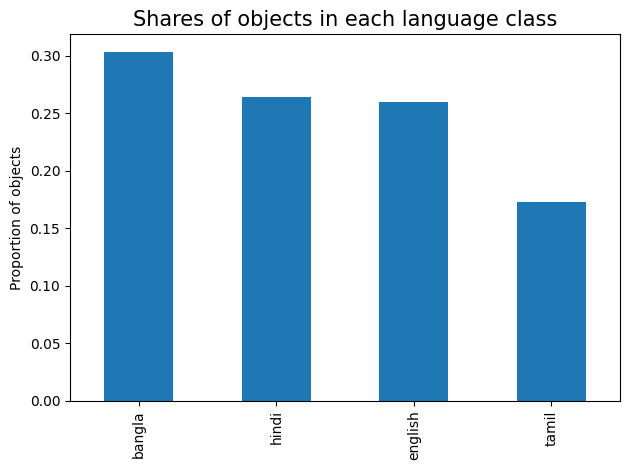

In [7]:
# Plotting the structure of the target variable
lang_counts = lang_data["label"].value_counts(normalize=True)
lang_counts.plot(kind="bar")
plt.title("Shares of objects in each language class", fontsize=15)
plt.ylabel("Proportion of objects")
plt.tight_layout()
plt.show()

# Encoding labels

In [8]:
# Retrieving the text data
texts_data = lang_data["text"].values.astype("U")

# Retrieving the labels data
labels_data = lang_data["label"].values

In [9]:
# Instantiating the LabelEncoder object
label_encoder = LabelEncoder()

# Encoding the labels
labels_data_encoded = label_encoder.fit_transform(labels_data)
class_names = label_encoder.classes_

# Displaying the encoding results
for idx, class_name in enumerate(class_names):
    print(f"{idx:<2} => {class_name}")

0  => bangla
1  => english
2  => hindi
3  => tamil


# Splitting data

In [10]:
# Separating data into training set and validation/test sets
(
training_texts,
validation_testing_texts,
training_labels,
validation_testing_labels
) = train_test_split(
    texts_data,
    labels_data_encoded,
    train_size=0.8,
    random_state=RANDOM_STATE,
    stratify=labels_data_encoded,
)

# Separating validation and test sets
(
validation_texts,
testing_texts,
validation_labels,
testing_labels
) = train_test_split(
    validation_testing_texts,
    validation_testing_labels,
    train_size=0.5,
    random_state=RANDOM_STATE,
    stratify=validation_testing_labels,
)

In [11]:
# Verifying the correctness of dimensions
assert (
    training_texts.shape[0] + validation_texts.shape[0] + testing_texts.shape[0] \
    == texts_data.shape[0]
)

# Displaying the number of objects in each set
training_texts.shape[0], validation_texts.shape[0], testing_texts.shape[0]

(52378, 6547, 6548)

# Data vizualization

In [12]:
def plot_target_structure(labels, fig_title="Title_1"):
    """Plotting the shares of Dataset labels."""
    # Computing the unique labels
    unique_labels = np.unique(labels)
    # Computing the number of objects within each class
    labels_count = np.bincount(labels)

    # Computing the shares of objects in each class
    n_obj = labels.shape[0]

    labels_info_share = pd.Series(
        labels_count, index=label_encoder.classes_
    ) / n_obj

    # Plotting a figure
    labels_info_share.plot(kind="bar")
    plt.xticks(rotation=0)
    plt.title(fig_title, fontsize=15)
    plt.xlabel("Class name")
    plt.ylabel("Proportion of objects")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

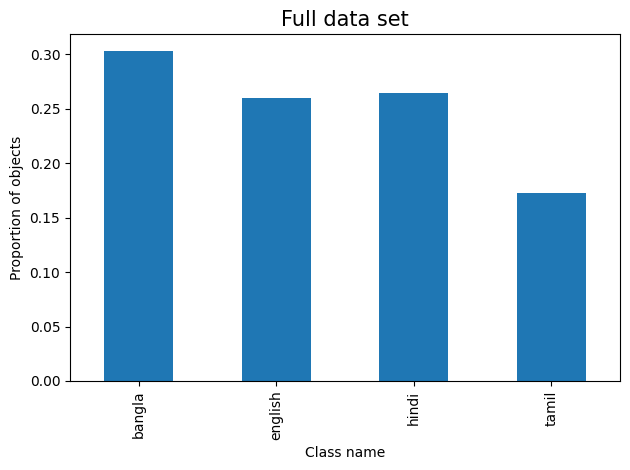

In [13]:
plot_target_structure(
    labels=labels_data_encoded, fig_title="Full data set"
)

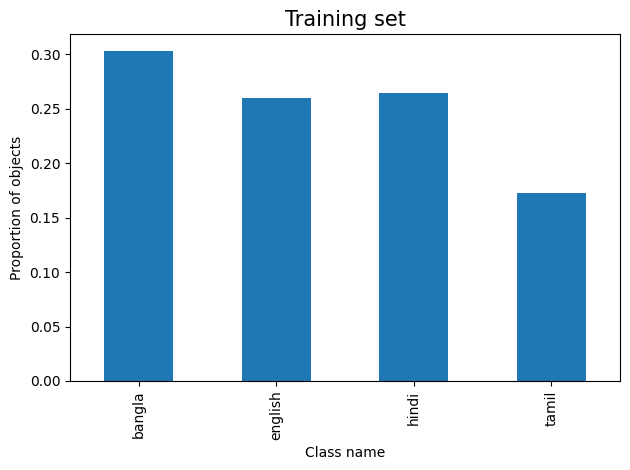

In [14]:
plot_target_structure(
    labels=training_labels, fig_title="Training set"
)

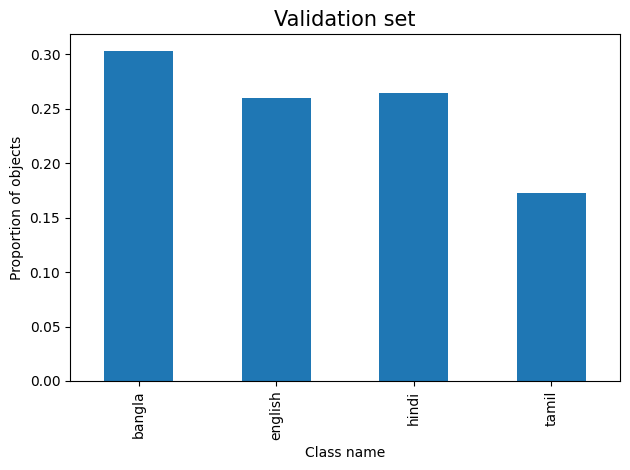

In [15]:
plot_target_structure(
    labels=validation_labels, fig_title="Validation set"
)

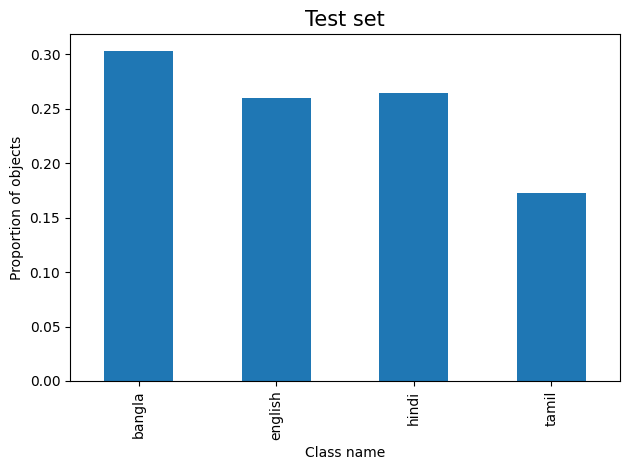

In [16]:
plot_target_structure(
    labels=testing_labels, fig_title="Test set"
)

# Tokenization

In [17]:
# Instantiating a BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [18]:
# Tokenizing the training examples
training_encodings = bert_tokenizer(
    list(training_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length",
)

# Tokenizing the validation examples
validation_encodings = bert_tokenizer(
    list(validation_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length",
)

# Tokenizing the testing examples
testing_encodings = bert_tokenizer(
    list(testing_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length",
)

In [19]:
def display_encodings_info(
    tokenizer,
    encodings,
    texts,
    labels,
    text_idx
):
    """Shows the original, encoded and decoded texts."""
    # Displaying the original text
    text = texts[text_idx]
    print(f"Input text:\n{text}\n")

    # Displaying the language of the text
    lang_label = labels[text_idx]
    lang = class_names[lang_label]
    print(f"Language: {lang}\n")

    # Displaying the encoded text
    text_encoded = encodings["input_ids"][text_idx]
    print(f"Tokenized input text (encoded):\n{text_encoded}\n")

    # Displaying the decoded text
    text_decoded = tokenizer.convert_ids_to_tokens(text_encoded)
    print(f"Tokenized input text (decoded):\n{text_decoded}")

In [20]:
display_encodings_info(
    tokenizer=bert_tokenizer,
    encodings=training_encodings,
    texts=training_texts,
    labels=training_labels,
    text_idx=990,
)

Input text:
i watched this and much like prometheus, i didn't get it. i watched it again. then i watched it with the directors commentary which led me back to prometheus and now i am watching it yet again. what director ridley scott is doing here is playing the long game. he is not going for a blockbuster hollywood hit. he is doing what movies and tales before movies were always meant to do. he is telling an epic story about creation and destruction as old as stories themselves. i believe i have it figured out but i must say i respect this director for going so deep and committing to such a long term project and delivering in all phases a story that touches on so many things so many can relate to. he is the story teller others will tell stories about. thank you for your gifts to us mere mortals ;o)

Language: english

Tokenized input text (encoded):
[101, 151, 84447, 10372, 10110, 12977, 11531, 59181, 117, 151, 30557, 112, 162, 13168, 10197, 119, 151, 84447, 10197, 12590, 119, 11120, 1

In [21]:
display_encodings_info(
    tokenizer=bert_tokenizer,
    encodings=validation_encodings,
    texts=validation_texts,
    labels=validation_labels,
    text_idx=1033,
)

Input text:
ekti besh boro ebong unchu, onnoti khubi choto jhopalo dhoroner.

Language: bangla

Tokenized input text (encoded):
[101, 14607, 10330, 40836, 10243, 22001, 10132, 66441, 13313, 10119, 25479, 117, 10125, 29734, 10116, 15290, 11880, 11268, 10366, 81347, 32421, 10687, 67875, 96009, 10177, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokenized input text (decoded):
['[CLS]', 'ek', '##ti', 'bes', '##h', 'bor', '##o', 'eb', '##ong', 'un', '##chu', ',', 'on', '##not', '##i', 'khu', '##bi', 'cho', '##to', 'jh', '##opa', '##lo', 'dh', '##oron', '##er', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

In [22]:
display_encodings_info(
    tokenizer=bert_tokenizer,
    encodings=testing_encodings,
    texts=testing_texts,
    labels=testing_labels,
    text_idx=1010,
)

Input text:
friday 5 baje ke liye alarm create kare

Language: hindi

Tokenized input text (encoded):
[101, 30318, 126, 12314, 10378, 11009, 11162, 12577, 68859, 18674, 56592, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokenized input text (decoded):
['[CLS]', 'friday', '5', 'ba', '##je', 'ke', 'li', '##ye', 'alarm', 'create', 'kare', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

# Creating Datasets and Dataloaders

In [23]:
class LanguageDataset(Dataset):
    """Class for creating a custom dataset."""

    def __init__(self, encodings, labels):
        """Constructor for LanguageDataset class."""
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        """Computes the number of the dataset objects."""
        dataset_length = len(self.labels)

        return dataset_length

    def __getitem__(self, idx):
        """Returns the corresponding samples for index given."""
        item = {key: torch.tensor(value[idx])
                for key, value in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])

        return item

In [24]:
# Initializing the training dataset
training_dataset = LanguageDataset(
    encodings=training_encodings,
    labels=training_labels,
)

# Initializing the validation dataset
validation_dataset = LanguageDataset(
    encodings=validation_encodings,
    labels=validation_labels,
)

# Initializing the testing dataset
testing_dataset = LanguageDataset(
    encodings=testing_encodings,
    labels=testing_labels,
)

In [25]:
# Creating a training Dataloader
training_dataloader = DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Creating a validation Dataloader
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Creating a testing Dataloader
testing_dataloader = DataLoader(
    testing_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [26]:
print(f"Training data examples: {len(training_dataloader.dataset):,}")
print(f"Number of batches: {len(training_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Training data examples: 52,378
Number of batches: 819
Batch size: 64


In [27]:
print(f"Validation data examples: {len(validation_dataloader.dataset)}")
print(f"Number of batches: {len(validation_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Validation data examples: 6547
Number of batches: 103
Batch size: 64


In [28]:
print(f"Testing data examples: {len(testing_dataloader.dataset):,}")
print(f"Number of batches: {len(testing_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Testing data examples: 6,548
Number of batches: 103
Batch size: 64


# Defining the BERT model

In [29]:
# Computing the number of classes
num_labels = len(class_names)

# Instantiating the BERT model
bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels
)

# Moving the model to DEVICE (GPU/CUDA)
bert_model.to(DEVICE)

# Defining the optimization algorithm
optimizer = torch.optim.Adam(bert_model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

In [30]:
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

# Computing accuracy

In [31]:
def acc_score(model, dataloader, device=DEVICE):
    """Computes the accuracy score for a DataLoader."""
    # Preallocating counter variables
    correct_predictions, num_examples = 0, 0

    # Turning off computing gradients
    with torch.no_grad():

        # Iteratively computing accuracy score (batch by batch)
        for batch_idx, batch in enumerate(dataloader):

            # Selecting the batch data (encodings, attention mask, labels)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Using BERT to compute logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]

            # Computing the predictions for labels
            predicted_labels = torch.argmax(logits, dim=1)

            # Computing the number of examples/correct predictions number
            num_examples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()

    # Computing the final accuracy score
    accuracy_score = correct_predictions.float() / num_examples

    return accuracy_score

# Fine-tuning loop

In [32]:
import torch
import time

def train_bert_model(
    model,
    optimizer,
    training_dataloader,
    validation_dataloader,
    accuracy_score_func=acc_score,
    epochs=2,
    batch_log_freq=100,
    device=DEVICE,
    checkpoint_path='bert_model_checkpoint.pth'
):
    """Launches the fine-tuning of BERT."""
    # Starting the timer
    start_time = time.time()

    # Going through all epochs
    for epoch in range(epochs):

        # Setting the model in the training mode
        model.train()

        # Going through all batches
        for batch_idx, batch in enumerate(training_dataloader):

            # Selecting the batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # BERT forward pass
            outputs = model(
                input_ids, attention_mask=attention_mask, labels=labels
            )
            loss, logits = outputs["loss"], outputs["logits"]

            # BERT backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging the progress
            if not batch_idx % batch_log_freq:
                print (f"Epoch {epoch+1:03d}/{epochs:03d} | "
                       f"Batch {batch_idx:03d}/{len(training_dataloader):03d} | "
                       f"Loss = {loss:.4f}")

        # Setting the model in the evaluation mode
        model.eval()

        # Disabling computing gradients
        with torch.set_grad_enabled(False):
            # Computing training accuracy
            training_accuracy_score = accuracy_score_func(
                model=model,
                dataloader=training_dataloader,
            )
            # Computing validation accuracy
            validation_accuracy_score = accuracy_score_func(
                model=model,
                dataloader=validation_dataloader,
            )
            # Logging the accuracy scores
            print(f"\nTraining accuracy = "
                  f"{training_accuracy_score:.4f}"
                  f"\nValid accuracy = "
                  f"{validation_accuracy_score:.4f}\n")

        # Save model checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }
        torch.save(checkpoint, checkpoint_path)

        # Printing the time passed at the end of the epoch
        time_elapsed_epoch = (time.time() - start_time) / 60
        print(f'Time elapsed: {time_elapsed_epoch:.2f} min\n')

    # Printing the total time spent on BERT fine-tuning
    time_elapsed_total = (time.time() - start_time) / 60
    print(f'\nTotal training Time: {time_elapsed_total:.2f} min')

    return model

In [33]:
'''# Training the BERT model
bert_model = train_bert_model(
    model=bert_model,
    optimizer=optimizer,
    training_dataloader=training_dataloader,
    validation_dataloader=validation_dataloader,
    epochs=NUM_EPOCHS,
    batch_log_freq=820,
)'''

'# Training the BERT model\nbert_model = train_bert_model(\n    model=bert_model,\n    optimizer=optimizer,\n    training_dataloader=training_dataloader,\n    validation_dataloader=validation_dataloader,\n    epochs=NUM_EPOCHS,\n    batch_log_freq=820,\n)'

In [34]:
def evaluate_test(model, dataloader, device=DEVICE):
    """Predicts the labels for the DataLoader."""
    # Setting up counter variables
    correct_preds, num_examples = 0, 0
    # Preallocating the list for test predictions
    test_predictions = []

    # Disabling computing gradients
    with torch.no_grad():

        # Iterating through all batches
        for batch_idx, batch in enumerate(dataloader):

            # Selecting the batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Computing logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]

            # Computing the predictions for labels
            predicted_labels_batch = torch.argmax(logits, dim=1)

            # Adding the batch predictions to the list
            test_predictions.append(predicted_labels_batch)

            # Iteratively computing accuracy determinants
            num_examples += labels.size(0)
            correct_preds += (predicted_labels_batch == labels).sum().cpu()

    # Computing final accuracy score
    test_accuracy_score = correct_preds.float() / num_examples

    # Transforming a list of tensors into one tensor
    test_predictions_tensor = torch.cat(test_predictions).cpu()

    return test_accuracy_score, test_predictions_tensor

In [35]:
checkpoint = torch.load("bert_model_checkpoint.pth")
bert_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [36]:
# Computing test accuracy and test predictions
accuracy_test, predictions_test = evaluate_test(
    model=bert_model, dataloader=testing_dataloader
)

print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.9791


# Testing the fine-tuned model on new data

In [37]:
# Creating a mapping of labels from pipeline to class names
label_mappings = dict()
for i in range(0, 4):
    label_mappings[f"LABEL_{i}"]= class_names[i].upper()

label_mappings

{'LABEL_0': 'BANGLA',
 'LABEL_1': 'ENGLISH',
 'LABEL_2': 'HINDI',
 'LABEL_3': 'TAMIL'}

In [38]:
# Defining the Transformers pipeline
bert_pipeline = pipeline(
    task="text-classification",
    model=bert_model,
    tokenizer=bert_tokenizer,
    device=DEVICE,
)

## Predicting one text

In [39]:
def define_lang_one_text(pipeline, test_text):
    """Outputs the language prediction for a sample text."""
    # Applying the pipeline to make predictions
    one_text_results = pipeline(test_text)[0]
    # Retrieving the probability
    proba = one_text_results["score"]
    # Retrieving the predicted label (encoded)
    predicted_label = one_text_results["label"]
    # Retieving the predicting language (decoded)
    predicted_lang = label_mappings[predicted_label]
    # Displaying the prediction
    print(f"Predicted language: {predicted_lang} ({proba:.2%} probability)")

In [40]:
# Creating a test text (English)
test_text = "It is interesting how we all turned out to be in the same place."
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: It is interesting how we all turned out to be in the same place.

Predicted language: ENGLISH (99.94% probability)


In [41]:
# Creating a test text Bangla
test_text = "moner kotha boltey chai"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: moner kotha boltey chai

Predicted language: BANGLA (99.96% probability)


In [42]:
# Creating a test text hindi
test_text = "cholo ghurey ashi"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: cholo ghurey ashi

Predicted language: BANGLA (99.94% probability)


In [43]:
# Creating a test text english
test_text = "work is important"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: work is important

Predicted language: ENGLISH (97.30% probability)


In [44]:
# Creating a test text bangla
test_text = "shobar logey work kora onk fun"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: shobar logey work kora onk fun

Predicted language: BANGLA (99.95% probability)


In [45]:
# Creating a test text bangla and english mixed
test_text = "Purai agun. but i want to see tumi kmn kaj koro. if you fail then its the end.So, come lets work together to finish this. cholo jai ghurey ashi. oi deshe"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: Purai agun. but i want to see tumi kmn kaj koro. if you fail then its the end.So, come lets work together to finish this. cholo jai ghurey ashi. oi deshe

Predicted language: BANGLA (99.65% probability)


In [46]:
# Creating a test text hindi
test_text = "tajnin amarey ekta girlfried khuija de.Tajnin joldi joldi ekta bondhur dayitto palon kor"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: tajnin amarey ekta girlfried khuija de.Tajnin joldi joldi ekta bondhur dayitto palon kor

Predicted language: BANGLA (99.95% probability)


## Predicting an array of texts

In [47]:
# Creating sample texts for classification
test_texts = [
    "It is impossible to do without a dictionary.",
    "mema paryeshanathmaka kruthiya wasara 10",
    "shobai ek logey thaka valo",
    "ka kalayak purawata ma romaye sita ehi lekhana ekineka piriksalamin imahath",
    "kya kar rahi ho?",
    "kepaweemen ha niwardiwa sampadanaya kale halawatha padawiye garu jo",
    "cholo kaj kori",
    "shokal hoise",
    "Interesting! I will look it up!",
]

# Applying the pipeline on all test texts
multiple_texts_results = bert_pipeline(test_texts)

# Outputting the results as DataFrame
multiple_texts_df = pd.DataFrame(multiple_texts_results)
multiple_texts_df["test_text"] = test_texts
multiple_texts_df["predicted_lang"] = multiple_texts_df["label"].map(
    label_mappings
)

# Rearranging the columns
multiple_texts_df[["test_text", "predicted_lang", "score"]]

,test_text,predicted_lang,score
0,It is impossible to do without a dictionary.,ENGLISH,0.977694
1,mema paryeshanathmaka kruthiya wasara 10,TAMIL,0.999670
2,shobai ek logey thaka valo,BANGLA,0.999561
3,ka kalayak purawata ma romaye sita ehi lekhana...,TAMIL,0.999721
4,kya kar rahi ho?,HINDI,0.992665
5,kepaweemen ha niwardiwa sampadanaya kale halaw...,TAMIL,0.999654
6,cholo kaj kori,BANGLA,0.999538
7,shokal hoise,BANGLA,0.994871
8,Interesting! I will look it up!,ENGLISH,0.997037


# Vizualizing the predictions

In [48]:
print(classification_report(
    y_true=testing_labels,
    y_pred=predictions_test,
    target_names=class_names,
)
     )

              precision    recall  f1-score   support

      bangla       0.97      0.98      0.97      1986
     english       0.98      1.00      0.99      1700
       hindi       0.98      0.96      0.97      1731
       tamil       0.98      0.98      0.98      1131

    accuracy                           0.98      6548
   macro avg       0.98      0.98      0.98      6548
weighted avg       0.98      0.98      0.98      6548



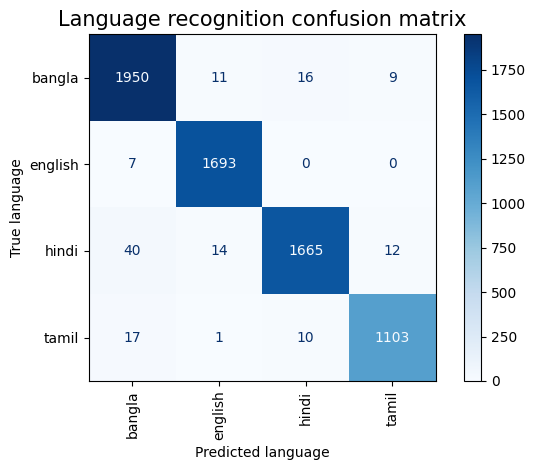

In [49]:
ConfusionMatrixDisplay.from_predictions(
    testing_labels,
    predictions_test,
    display_labels=class_names,
    cmap="Blues",
)
plt.xticks(rotation=90)
plt.xlabel("Predicted language")
plt.ylabel("True language")
plt.title("Language recognition confusion matrix", fontsize=15)
plt.tight_layout()
plt.show()

In [50]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.8 MB/s eta 0:00:00


In [51]:
import torch
from captum.attr import LayerIntegratedGradients, visualization as viz
tokenizer = bert_tokenizer
def predict(inputs):
    return bert_model(inputs)[0]

In [52]:
ref_token_id = bert_tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = bert_tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = bert_tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [53]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [78]:
def custom_forward(inputs):
    preds = predict(inputs)
    #return torch.softmax(preds, dim = 1)[:, 0] # for negative attribution,
    return   torch.softmax(preds, dim = 1)[:, 3] #<- for positive attribution

In [79]:
lig = LayerIntegratedGradients(custom_forward, bert_model.bert.embeddings)

In [80]:
# One can test a couple of examples and check that the sentiment classifier is behaving
#text = "Dune is a really good movie. I liked that movie very much. "
text = "mema paryeshanathmaka kruthiya wasara 10 ka kalayak purawata ma romaye sita ehi lekhana ekineka piriksalamin imahath kepaweemen ha niwardiwa sampadanaya kale halawatha padawiye garu jo."

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [82]:
predict(input_ids)

tensor([[-1.7655, -2.7992, -2.8332,  6.6280]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [83]:
# Check predict output
pred = predict(input_ids)
torch.softmax(pred, dim = 1)

tensor([[2.2626e-04, 8.0474e-05, 7.7789e-05, 9.9962e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [84]:
# Check output of custom_forward
custom_forward(input_ids)

tensor([0.9996], device='cuda:0', grad_fn=<SelectBackward0>)

In [85]:
attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=1500,
                                    internal_batch_size=32,
                                    return_convergence_delta=True)
delta

tensor([-0.0015], device='cuda:0', dtype=torch.float64)

In [86]:
score = predict(input_ids)

print('Sentence: ', text)
print('Sentiment: ' + str(torch.argmax(score[0]).cpu().numpy()) + \
      ', Probability positive: ' + str(torch.softmax(score, dim = 0)[0][0].cpu().detach().numpy()))

Sentence:  mema paryeshanathmaka kruthiya wasara 10 ka kalayak purawata ma romaye sita ehi lekhana ekineka piriksalamin imahath kepaweemen ha niwardiwa sampadanaya kale halawatha padawiye garu jo.
Sentiment: 3, Probability positive: 1.0


In [87]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [88]:
attributions_sum = summarize_attributions(attributions)

In [91]:
# storing couple samples in an array for visualization purposes
score_vis = viz.VisualizationDataRecord(attributions_sum,
                                        torch.softmax(score, dim = 0)[0][0],
                                        torch.argmax(score[0]),
                                        3,
                                        text,
                                        attributions_sum.sum(),
                                        all_tokens,
                                        delta)

In [92]:
print('\033[1m', 'Visualization For Score', '\033[0m')
viz.visualize_text([score_vis])

 Visualization For Score 
